In [1]:
import itertools
import numpy as np
from numpy.random import random, randn
from scipy import math
import matplotlib.pyplot as plt
from scipy.linalg import eig, inv, expm
from scipy.integrate import ode
from scipy.optimize import curve_fit, basinhopping, minimize_scalar, minimize
import pandas as pd
import seaborn as sns
import os

$$\rightarrow S_0 
~~~~\overset{v_1}{\underset{0}{\rightleftarrows}} ~~~~\underset{\downarrow \mu s_1}{S_1}~~~~
\overset{v_2}{\underset{x~\mu\cdot s_1}{\rightleftarrows}}~~~~ \underset{\downarrow \mu s_2}{S_2}~~~~
\overset{v_3}{\underset{0}{\rightleftarrows}} ~~~~\underset{\downarrow \mu s_3}{S_3}
$$

In [2]:
def solve_for_M(M: np.array):
    n = int(np.sqrt(len(M.flat)))
    M = M.reshape(n, n)
    f0 = np.array([0.0] + [1.0]*(n-1), dtype=float)
    w, U = eig(M, right=True)
    x0 = inv(U) @ f0
    A = U @ np.diag(x0)
    W = np.array(w.real, ndmin=2).T
    return A, W

def solve_for_s(s1, s2, s3, x):
    """
        x is the reverse flux divided by s2
    """
    M = np.array([[0.0, 0.0, 0.0, 0.0],
                  [(s1+s2+s3)/s1, -(s1+s2+s3)/s1 - x*s2/s1, x*s2/s1, 0],
                  [0.0, (s2+s3)/s2 + x, -(s2+s3)/s2 - x, 0.0],
                  [0.0, 0.0, 1.0, -1.0]
                 ])
    A, W =  solve_for_M(M)
    t_range = np.linspace(0, 10, 1000)
    f_data = np.exp(W @ np.array(t_range, ndmin=2)).T @ A.T
    f_tot = f_data @ (np.array([0, s1, s2, s3]) / (s1+s2+s3))
    return f_data, f_tot

## Reversibility causes pool size redundency

When the reaction from $s_1$ to $s_2$ is reversible, the response of $f_2$ to $f_{tot}$ will look the same as an irreversible one, with a smaller precursor pool $\varphi_1 = \phi_1 / (1+x)$:

$$f_2 ~=~ -\frac{\varphi_1}{1 - \varphi_1} f_{tot}^{1/\varphi_1} ~+~ \frac{1}{1 - \varphi_1} f_{tot}$$


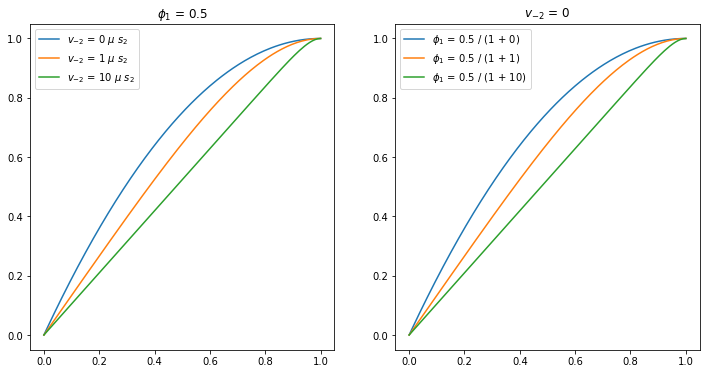

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

phi1 = 0.5
ax = axs.flat[0]
for x in [0.0, 1.0, 10.0]:
    f_data, f_tot = solve_for_s(phi1, 1-phi1, 0, x)
    ax.plot(f_tot, f_data[:, 2], label=f"$v_{{-2}}$ = ${x:g}~\mu~s_2$");
ax.set_title(f"$\phi_1$ = {phi1}")
ax.legend()

ax = axs.flat[1]
for x in [0.0, 1.0, 10.0]:
    f_data, f_tot = solve_for_s(phi1/(1.0+x), 1.0 - phi1/(1.0+x), 0, 0)
    ax.plot(f_tot, f_data[:, 2], label=f"$\phi_1$ = {phi1} / (1 + {x:g})");
ax.set_title(f"$v_{{-2}}$ = 0")
ax.legend();

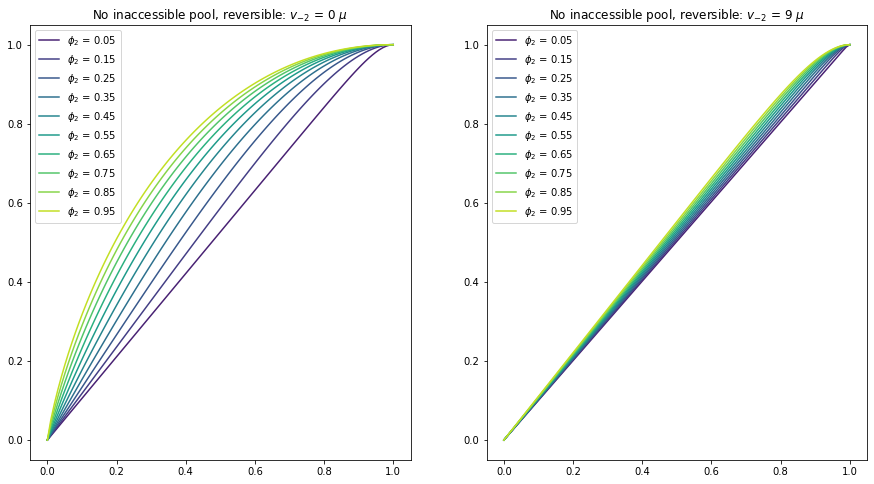

In [4]:
def f2(ftot, phi1, x):
    return ((1+x)*ftot - phi1*ftot**((x+1)/phi1)) / (1 + x - phi1)

n_colors = 10
palette = itertools.cycle(sns.color_palette("viridis", n_colors=n_colors))
ftot_range = np.linspace(0, 1, 100)
phi1_range = np.linspace(0.05, 0.95, n_colors)

fig, axs = plt.subplots(1, 2, figsize=(15, 8))

for ax, x in zip(axs.flat, [0.0, 9.0]):
    for phi1 in phi1_range:
        ax.plot(ftot_range,
                [f2(ftot, phi1, x) for ftot in ftot_range],
                label=f"$\phi_2$ = {phi1:.2f}", color=next(palette))
    ax.set_title(f"No inaccessible pool, reversible: $v_{{-2}}$ = ${x:g}~\mu$")
    ax.legend()

# apply reversible model on measured data

In [5]:
from karma import RES_DIR, DATA_DIR
DATA_FNAME = os.path.join(
        DATA_DIR,
        "2019-09-20_lableing_NUPs_NTR-timer_raw_and_lysine-corr.tsv")
data_df = pd.read_csv(DATA_FNAME, delimiter="\t")
data_df.Time = data_df.Time.str[1:].apply(float)
data_df.drop(["labeling.raw", "NTR.timer.raw"], axis=1, inplace=True)
data_df.rename(columns={"gene": "prey",
                        "Handle": "bait",
                        "labeling.lysine.corr": "labeling",
                        "NTR.timer.lysine.corr": "timer",
                        }, inplace=True)
data_df.labeling = 1.0 - data_df.labeling
data_df.timer = 1.0 - data_df.timer


timer_df = data_df[["bait", "Time", "Replicate", "timer"]].drop_duplicates()
timer_df = timer_df.groupby(["bait", "Time"]).agg(["mean", "std"])[["timer"]].copy()
timer_df.columns = timer_df.columns.to_flat_index().map("_".join)

clusters = {
    "NUP85": ["NUP120", "NUP85"],
    "NUP133": ["NUP133", "NUP145C", "NUP84"],
    "*ASM4": ["NUP170", "NUP53", "POM152", "POM34"],
    "NUP1": ["NUP1"],
    "NUP159": ["NUP159", "NUP82"],
    "NUP57": ["NUP49", "NUP57"],
    "NUP188": ["NUP188"],
    "*MLP2": ["MLP2"],
    "MLP1": ["MLP1"]
}
data_df["cluster"] = ""
for k, v in clusters.items():
    data_df.loc[data_df.prey.isin(v), "cluster"] = k

# drop data of preys that are in none of the clusters
cluster_data_df = data_df.loc[data_df.cluster != "", :]
cluster_data_df.drop("prey", axis=1, inplace=True)
cluster_data_df.rename(columns={"cluster": "prey"}, inplace=True)

agg_data_df = cluster_data_df.groupby(
    ["bait", "prey", "Time"]).agg(["mean", "std"])[["labeling"]]
agg_data_df.columns = agg_data_df.columns.to_flat_index().map("_".join)
agg_data_df = agg_data_df.reset_index()
agg_data_df = agg_data_df.join(timer_df, on=["bait", "Time"])

/home/eladn/git/karma/venv/lib/python3.9/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/eladn/git/karma/venv/lib/python3.9/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


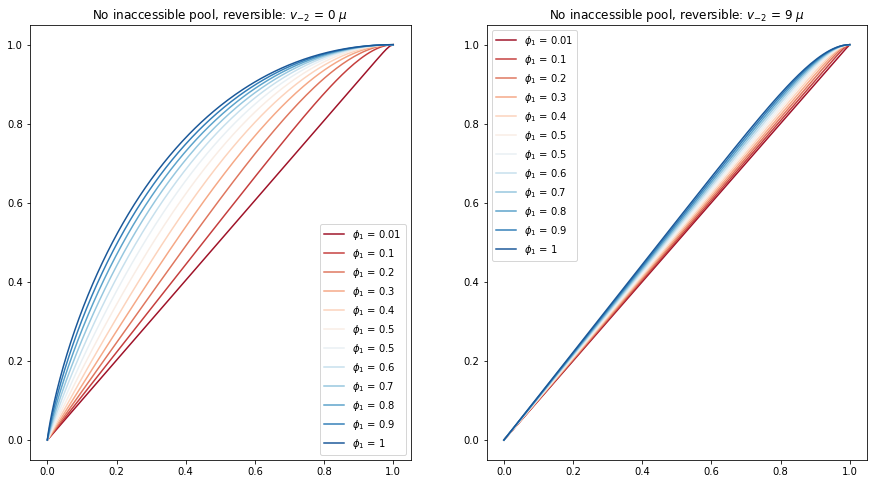

In [6]:
n_colors = 12
palette = itertools.cycle(sns.color_palette("RdBu", n_colors=n_colors))
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
for ax, x in zip(axs.flat, [0.0, 9.0]):
    for phi1 in np.linspace(0.01, 0.99, n_colors):
        f_data, f_tot = solve_for_s(phi1, 1-phi1, 0, x)
        ax.plot(f_tot, f_data[:, 2], label=f"$\phi_1$ = {phi1:.1g}", color=next(palette))
    ax.set_title(f"No inaccessible pool, reversible: $v_{{-2}}$ = ${x:g}~\mu$")
    ax.legend()

In [7]:
agg_data_df

bait   prey  Time  labeling_mean  labeling_std  timer_mean  timer_std
0     MLP1  *ASM4   0.0       1.000000      0.000000    1.000000   0.000000
1     MLP1  *ASM4  30.0       0.915471      0.016951    0.813574   0.002904
2     MLP1  *ASM4  60.0       0.817871      0.023897    0.668148   0.002832
3     MLP1  *ASM4  90.0       0.719508      0.024459    0.552094   0.004309
4     MLP1  *MLP2   0.0       1.000000      0.000000    1.000000   0.000000
..     ...    ...   ...            ...           ...         ...        ...
355  NUP85  NUP57  90.0       0.631732      0.003021    0.560263   0.002630
356  NUP85  NUP85   0.0       1.000000      0.000000    1.000000   0.000000
357  NUP85  NUP85  30.0       0.802506      0.024377    0.816761   0.004984
358  NUP85  NUP85  60.0       0.660082      0.024022    0.676637   0.007123
359  NUP85  NUP85  90.0       0.545584      0.016491    0.560263   0.002630

[360 rows x 7 columns]

[-1.88154029e-24 -3.90625024e+00]
[[0.01638673 0.        ]
 [0.         0.        ]]


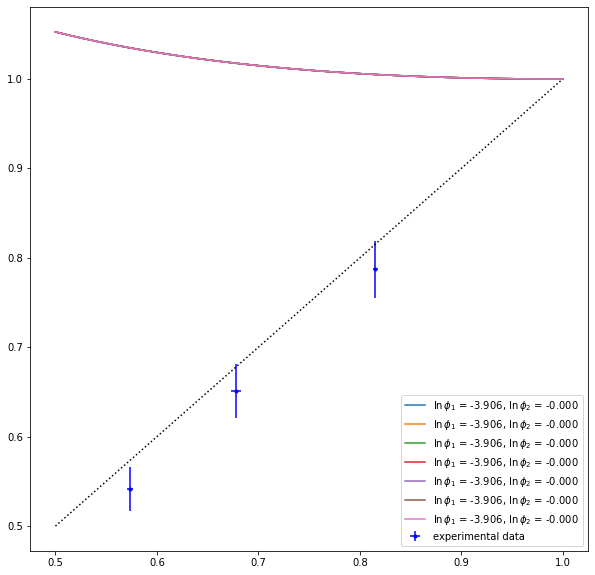

In [8]:
bait = "NUP84"; prey = "NUP133"
#bait = "NUP133"; prey = "NUP85"
#bait = "NUP82"; prey = "NUP1"
#bait = "MLP1"; prey = "*ASM4"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

df = agg_data_df[(agg_data_df.prey == prey) & (agg_data_df.bait == bait) & (agg_data_df.Time > 0)]
ax.errorbar(x=df.timer_mean,
            y=df.labeling_mean,
            xerr=df.timer_std,
            yerr=df.labeling_std,
            fmt=".b",
            label="experimental data")
ax.plot([0.5, 1], [0.5, 1], 'k:')

popt, pcov = curve_fit(
    f2, xdata=df.timer_mean,
    ydata=df.labeling_mean,
    sigma=df.labeling_std,
    p0=(np.log(0.2), np.log(0.5)), bounds=[(-10, -5), (0, 0)])

print(popt)
print(pcov)

ftot_range = np.linspace(0.5, 1, 100)

if popt[0] > popt[1]:
    ln_phi2 = popt[0]
    i = 1
else:
    ln_phi2 = popt[1]
    i = 0

for x in np.linspace(-1, 1, 7):
    ln_phi1 = popt[i] + x*pcov[1, 1]
    if ln_phi1 > ln_phi2:
        continue
    f2_values = list(map(lambda ftot: f2(ftot, ln_phi1, ln_phi2), ftot_range))
    ax.plot(ftot_range, f2_values, '-', label=f"$\ln\phi_1$ = {ln_phi1:.3f}, $\ln\phi_2$ = {ln_phi2:.3f}")

ax.legend()

In [9]:
pcov

array([[0.01638673, 0.        ],
       [0.        , 0.        ]])

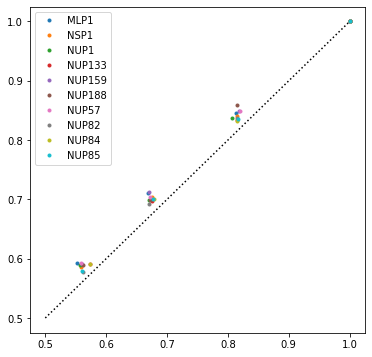

In [10]:
prey = "NDC1"

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for bait, bait_df in data_df[data_df.prey == prey].groupby("bait"):
    agg_df = bait_df.groupby("Time").mean()
    ax.plot(agg_df.timer, agg_df.labeling, '.', label=bait)

ax.plot([0.5, 1], [0.5, 1], "k:")
ax.legend()